# Hotel Recommendation System

In [190]:
import nltk
nltk.download('wordnet')
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


[nltk_data] Downloading package wordnet to C:\Users\Sabin
[nltk_data]     Sapkota\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [212]:
df=pd.read_csv(r'C:\Users\Sabin Sapkota\Desktop\Hotel_reviews.csv')

In [213]:
df.head(2)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968


In [74]:
df.shape

(515738, 17)

In [75]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [214]:
# to see unique value in each column
df.apply(lambda x:len(x.unique()))

Hotel_Address                                   1493
Additional_Number_of_Scoring                     480
Review_Date                                      731
Average_Score                                     34
Hotel_Name                                      1492
Reviewer_Nationality                             227
Negative_Review                               330011
Review_Total_Negative_Word_Counts                402
Total_Number_of_Reviews                         1142
Positive_Review                               412601
Review_Total_Positive_Word_Counts                365
Total_Number_of_Reviews_Reviewer_Has_Given       198
Reviewer_Score                                    37
Tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
dtype: int64

In [215]:
#columns with missing value
[col for col in df.columns if df[col].isnull().any()]

['lat', 'lng']

In [216]:
#missing value
df.isna().sum()

Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
dtype: int64

In [217]:
#extracting country from hotel address

df['country']=df.Hotel_Address.apply(lambda x: x.split(' ')[-1])

In [218]:
df['country']=df.country.str.replace('Kingdom','UK')

In [219]:
#these are unique value
#so,these are the hotel from these 5 countries
df.country.unique()

array(['Netherlands', 'UK', 'France', 'Spain', 'Italy', 'Austria'],
      dtype=object)

In [220]:
# droping columns which are unnecessary for this project
df.drop(['Additional_Number_of_Scoring',
       'Review_Date','Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'days_since_review', 'lat', 'lng'],1,inplace=True)

In [221]:
# shape after dropping unnecessary columns
df.shape

(515738, 5)

Before going build recommendation model i will explore data and try to extract information


# Number of hotels by country

In [234]:
df1=df.groupby('country')['Hotel_Name'].agg('count').reset_index()
df1.columns=['country','total_number']
df1=df1.sort_values(by='total_number',ascending=False)
df1

,country,total_number
5,UK,262301
4,Spain,60149
1,France,59928
3,Netherlands,57214
0,Austria,38939
2,Italy,37207


In [237]:
px.pie(data_frame=df1,names='country',values='total_number',hole=0.5,
       title='Total number of the hotel by country')

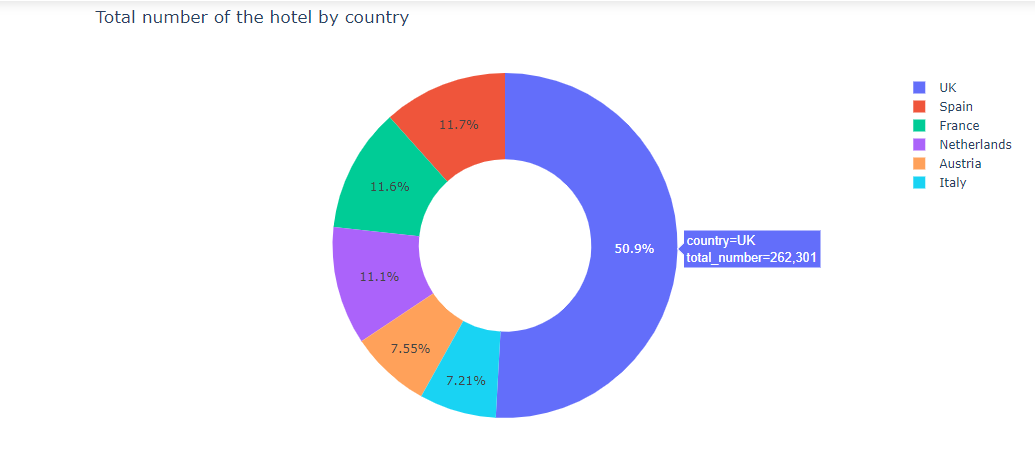

In [ ]:
So, in this dataset, most of the hotel are from UK.

# Average rating by country

In [253]:
df1=df.groupby('country')['Average_Score'].agg('mean').reset_index()
df1.Average_Score=df1.Average_Score.apply(lambda x:round(x,1))
df1=df1.sort_values(by='Average_Score',ascending=False)

df1

,country,Average_Score
0,Austria,8.6
4,Spain,8.5
1,France,8.4
2,Italy,8.4
3,Netherlands,8.4
5,UK,8.3


In [254]:
px.bar(data_frame=df1,x='country',y='Average_Score',text='Average_Score',
      title='average rating by country')

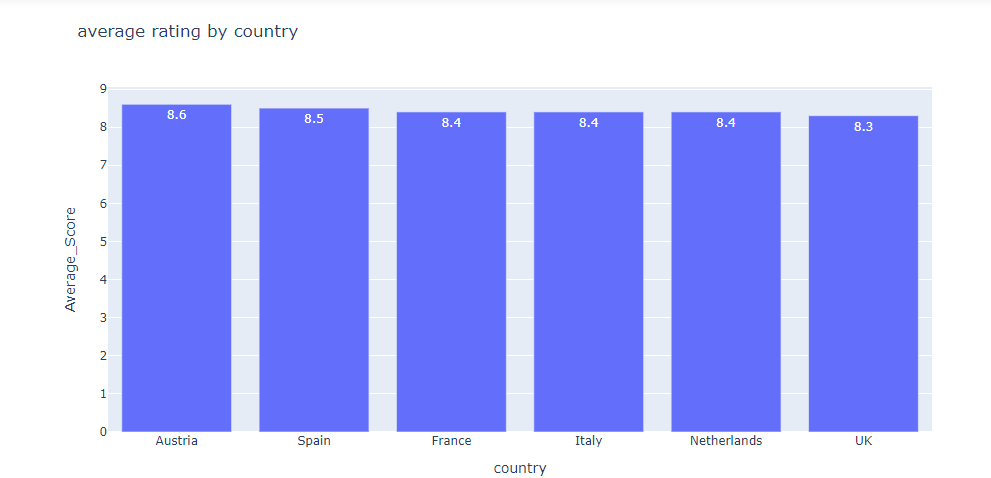

In [ ]:
So, austria has best average rating

# Top 10 rating hotel by their country

In [225]:
df.columns

Index(['Hotel_Address', 'Average_Score', 'Hotel_Name', 'Tags', 'country'], dtype='object')

In [255]:
df1=df.groupby('Hotel_Name')['country','Average_Score'].agg('max')
df1=df1.reset_index()
df1.columns=['Hotel_Name','country','Max_score']
df1=df1.sort_values(by='Max_score',ascending=False,ignore_index=True)
df1=df1.head(10)
df1=df1.sort_values(by='Max_score')
df1
#top 10 rating hotel by country

,Hotel_Name,country,Max_score
7,Milestone Hotel Kensington,UK,9.5
8,Taj 51 Buckingham Gate Suites and Residences,UK,9.5
9,Hotel Sacher Wien,Austria,9.5
1,41,UK,9.6
2,H tel de La Tamise Esprit de France,France,9.6
3,Haymarket Hotel,UK,9.6
4,Hotel The Serras,Spain,9.6
5,H10 Casa Mimosa 4 Sup,Spain,9.6
6,Hotel Casa Camper,Spain,9.6
0,Ritz Paris,France,9.8


In [256]:
px.bar(data_frame=df1,y='Hotel_Name',x='Max_score',text='Max_score',
      title='top 10 hotel with highest rating')

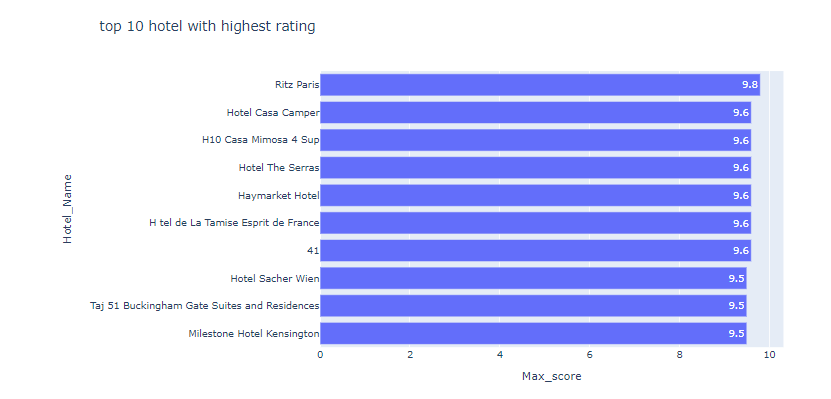

In [ ]:
So, maximum rating were given to hotel Ritz Paris,which is the the France.To see total number
of such hotel, we can use

In [202]:
def hotel_count(text):
    """function that returns total number of hotel"""
    return (df.Hotel_Name==text).sum()
hotel_count('Ritz Paris')
#So, there are 28 hotel named Ritz Paris having rating 9.8

28

In [203]:
hotel_count('41')
#so there are 103 hotel named 41 having rating 9.6

103

In [ ]:
#Now lets build the recommendation model

In [91]:
#first we need to clean the columns tags
def impute(column):
    column = column[0]
    if (type(column) != list):
        return "".join(literal_eval(column))
    else:
        return column
    
df["Tags"] = df[["Tags"]].apply(impute, axis=1)
df.head()

,Hotel_Address,Average_Score,Hotel_Name,Tags,country
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,7.7,Hotel Arena,Leisure trip Couple Duplex Double Room Sta...,Netherlands
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,7.7,Hotel Arena,Leisure trip Couple Duplex Double Room Sta...,Netherlands
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,7.7,Hotel Arena,Leisure trip Family with young children Dup...,Netherlands
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,7.7,Hotel Arena,Leisure trip Solo traveler Duplex Double Ro...,Netherlands
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,7.7,Hotel Arena,Leisure trip Couple Suite Stayed 2 nights ...,Netherlands


In [94]:
#change to lower case
df['country'] = df['country'].str.lower()
df['Tags'] = df['Tags'].str.lower()

In [99]:
#we make a function to build hotel recommendation system
def recommend_hotel(location, description):
    description = description.lower()
    word_tokenize(description)
    stop_words = stopwords.words('english')
    lemm = WordNetLemmatizer()
    filtered  = {word for word in description if not word in stop_words}
    filtered_set = set()
    for fs in filtered:
        filtered_set.add(lemm.lemmatize(fs))

    country = data[data['country']==location.lower()]
    country = country.set_index(np.arange(country.shape[0]))
    list1 = []; list2 = []; cos = [];
    for i in range(country.shape[0]):
        temp_token = word_tokenize(country["Tags"][i])
        temp_set = [word for word in temp_token if not word in stop_words]
        temp2_set = set()
        for s in temp_set:
            temp2_set.add(lemm.lemmatize(s))
        vector = temp2_set.intersection(filtered_set)
        cos.append(len(vector))
    country['similarity']=cos
    country = country.sort_values(by='similarity', ascending=False)
    country.drop_duplicates(subset='Hotel_Name', keep='first', inplace=True)
    country.sort_values('Average_Score', ascending=False, inplace=True)
    country.reset_index(inplace=True)
    return country[["Hotel_Name", "Average_Score", "Hotel_Address"]].head()

In [104]:
recommend_hotel('France', 'I am going to work')

,Hotel_Name,Average_Score,Hotel_Address
0,Ritz Paris,9.8,15 Place Vend me 1st arr 75001 Paris France
1,H tel de La Tamise Esprit de France,9.6,4 rue d Alger 1st arr 75001 Paris France
2,Le Narcisse Blanc Spa,9.5,19 Boulevard De La Tour Maubourg 7th arr 75007...
3,Hotel The Peninsula Paris,9.5,19 avenue Kleber 16th arr 75116 Paris France
4,Nolinski Paris,9.4,16 Avenue de l Opera 1st arr 75001 Paris France


In [252]:
recommend_hotel('Austria', 'I am going to honeymoon')

,Hotel_Name,Average_Score,Hotel_Address
0,Hotel Sacher Wien,9.5,Philharmoniker Stra e 4 01 Innere Stadt 1010 V...
1,Palais Coburg Residenz,9.5,Coburgbastei 4 01 Innere Stadt 1010 Vienna Aus...
2,Best Western Premier Kaiserhof Wien,9.4,Frankenberggasse 10 04 Wieden 1040 Vienna Austria
3,The Guesthouse Vienna,9.4,F hrichgasse 10 01 Innere Stadt 1010 Vienna Au...
4,Hotel Sans Souci Wien,9.4,Burggasse 2 07 Neubau 1070 Vienna Austria
